Preparing data for semantic segmentation
===

In [1]:
import os
import json

import fiftyone as fo
import fiftyone.zoo as foz

import pandas as pd
from sklearn.model_selection import train_test_split

from loguru import logger

## Download COCO-2017 dataset

* Selected Classes:
   * person
   * car
   * bus
   * truck

* Filtering by size

In [2]:
# cleanup old datasets
for ds in fo.list_datasets():
    fo.delete_dataset(ds)

In [3]:
selected_classes = [
    "person", "car", "bus", "truck"
]

dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["train", "validation"],
    classes=selected_classes,
    max_samples=10000,
    only_matching=True,
    label_types=["segmentations"]
)


Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_val2017.json'
Only found 2930 (<10000) samples matching your requirements
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'train'
 100% |█████████████| 10000/10000 [32.6s elapsed, 0s remaining, 385.7 samples/s]      
Loading 'coco-2017' split 'validation'
 100% |███████████████| 2930/2930 [7.6s elapsed, 0s remaining, 421.3 samples/s]       
Dataset 'coco-2017-train-validation-10000' created


In [4]:
sample = dataset.first()

sample["ground_truth.detections"][0]

<Detection: {
    'id': '66ff28b80c91ce8685295056',
    'attributes': {},
    'tags': [],
    'label': 'person',
    'bounding_box': [
        0.26045833333333335,
        0.21404687500000003,
        0.4286875,
        0.665171875,
    ],
    'mask': array([[False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           ...,
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False]]),
    'confidence': None,
    'index': None,
    'supercategory': 'person',
    'iscrowd': 0,
}>

person 0.0907421875
<Detection: {
    'id': '66ff28b80c91ce8685295056',
    'attributes': {},
    'tags': [],
    'label': 'person',
    'bounding_box': [
        0.26045833333333335,
        0.21404687500000003,
        0.4286875,
        0.665171875,
    ],
    'mask': array([[False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           ...,
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False]]),
    'confidence': None,
    'index': None,
    'supercategory': 'person',
    'iscrowd': 0,
}>


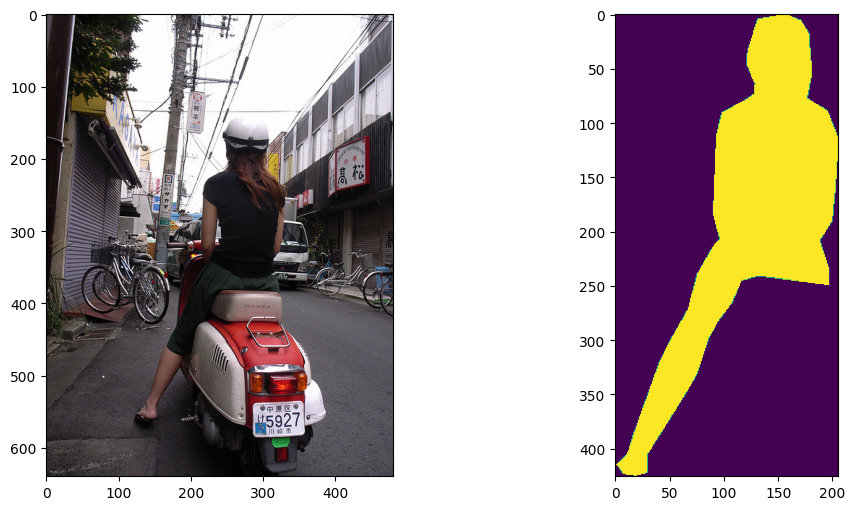

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open(sample["filepath"])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, annot in enumerate(sample["ground_truth.detections"]):
    label = annot["label"]
    mask = annot["mask"]
    area_ratio = np.sum(mask) / (img.size[0] * img.size[1])
    print(label, area_ratio)
    if (label in selected_classes) and (area_ratio > 0.01):
        break


print(sample["ground_truth.detections"][idx])
axes[0].imshow(img)
mask_cropped = sample["ground_truth.detections"][idx]["mask"]
axes[1].imshow(mask_cropped)
plt.show()

In [6]:
values = np.linspace(0, 255, len(selected_classes) + 1, dtype="uint8")
print(values)
# 0: background
class_values = {
    label: value for label, value in zip(selected_classes, values[1:])
}
print(class_values)

[  0  63 127 191 255]
{'person': 63, 'car': 127, 'bus': 191, 'truck': 255}


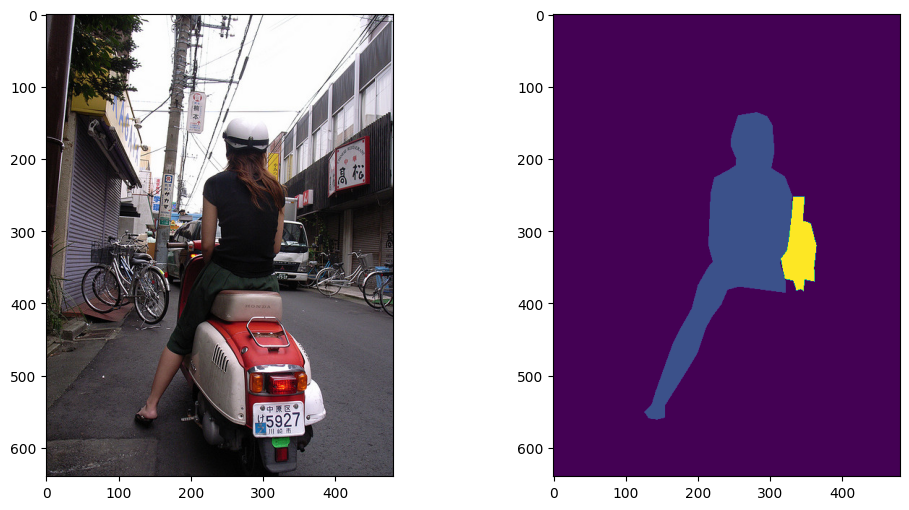

In [7]:

def reconstruct_fullsized_mask(mask_cropped, box, img_width, img_height):
    box = [
        int(box[0] * img_width),
        int(box[1] * img_height),
        mask_cropped.shape[1] + int(box[0] * img_width),
        mask_cropped.shape[0] + int(box[1] * img_height)
    ]

    mask = np.zeros((img_height, img_width), dtype=bool)
    mask[box[1]:box[3], box[0]:box[2]] = mask_cropped

    return mask


def generate_semantic_mask(sample, selected_classes):
    img = Image.open(sample["filepath"])
    img_width, img_height = img.size
    mask = np.zeros((img_height, img_width), dtype="uint8")
    # spread values equally in range [0-255]

    for annot in sample["ground_truth.detections"]:
        label = annot["label"]
        mask_cropped = annot["mask"]
        box = annot["bounding_box"]
        area_ratio = np.sum(mask_cropped) / (img.size[0] * img.size[1])

        if label not in selected_classes or area_ratio < 0.01:
            continue

        m = reconstruct_fullsized_mask(mask_cropped, box, img_width, img_height)
        mask[m] = class_values[label]

    return mask

# get this sample : /home/pyml/fiftyone/coco-2017/validation/data/000000581357.jpg
sample = dataset.first()
img = Image.open(sample["filepath"])
mask = generate_semantic_mask(sample, selected_classes)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[1].imshow(mask)
plt.show()

In [8]:
from tqdm import tqdm

img_dir = "data/images"
mask_dir = "data/masks"
os.makedirs(img_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

list_samples = []
for sample in tqdm(dataset):
    filename = os.path.basename(sample["filepath"])
    basename = filename.replace('.jpg', '').replace('.png', '')
    mask = generate_semantic_mask(sample, selected_classes)
    # check if any label is present
    if not np.any(mask):
        continue
    image_path = os.path.join(img_dir, f"{basename}.jpg")
    Image.open(sample["filepath"]).save(image_path)
    mask_path = os.path.join(mask_dir, f"{basename}.png")
    Image.fromarray(mask).save(mask_path)
    list_samples.append({
        "imagepath": image_path,
        "maskpath": mask_path,
        "split": sample["tags"][0]
    })

logger.info(f"Generated {len(list_samples)} samples with semantic masks")

100%|██████████| 12930/12930 [00:48<00:00, 268.17it/s]
2024-10-03 18:30:25.960 | INFO     | __main__:<module>:26 - Generated 11152 samples with semantic masks


In [9]:
df = pd.DataFrame(list_samples)
df.head()

,imagepath,maskpath,split
0,data/images/000000001315.jpg,data/masks/000000001315.png,train
1,data/images/000000001523.jpg,data/masks/000000001523.png,train
2,data/images/000000002089.jpg,data/masks/000000002089.png,train
3,data/images/000000003988.jpg,data/masks/000000003988.png,train
4,data/images/000000004130.jpg,data/masks/000000004130.png,train


<Axes: title={'center': 'Number of samples per split'}, xlabel='split'>

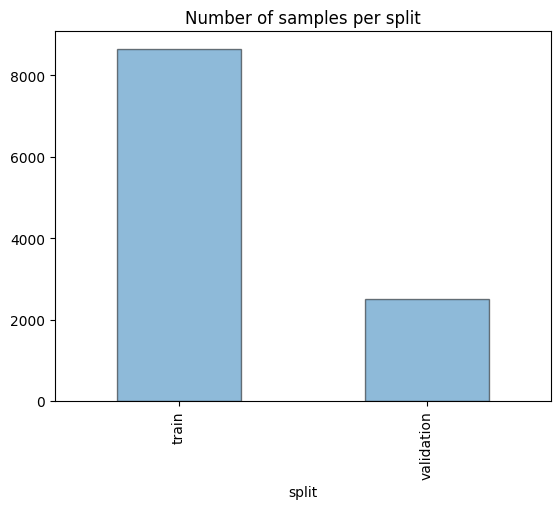

In [10]:
# bar plot of train/test/validation split
df["split"].value_counts().plot(
    kind="bar", alpha=0.5, edgecolor="black",
    title="Number of samples per split"
)

In [11]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['split'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['split'] == 'validation'])}")

2024-10-03 18:30:26.038 | INFO     | __main__:<module>:1 - Number of samples: 11152
2024-10-03 18:30:26.040 | INFO     | __main__:<module>:2 - Number of Train samples: 8643
2024-10-03 18:30:26.040 | INFO     | __main__:<module>:3 - Number of Validation samples: 2509


In [12]:
# use current validation set as test set
df_test = df[df["split"] == "validation"].reset_index(drop=True)
df_test["split"] = "test"

# split train -> train/val (80%/20%)
df_train = df[df["split"] == "train"].reset_index(drop=True)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
df_train["split"] = "train"
df_val["split"] = "val"

# concatenate
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

df.to_csv("data/data.csv", index=False)

In [13]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['split'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['split'] == 'val'])}")
logger.info(f"Number of Test samples: {len(df[df['split'] == 'test'])}")


2024-10-03 18:30:26.065 | INFO     | __main__:<module>:1 - Number of samples: 11152
2024-10-03 18:30:26.066 | INFO     | __main__:<module>:2 - Number of Train samples: 6914
2024-10-03 18:30:26.067 | INFO     | __main__:<module>:3 - Number of Validation samples: 1729
2024-10-03 18:30:26.067 | INFO     | __main__:<module>:4 - Number of Test samples: 2509
